<a href="https://colab.research.google.com/github/maekala/Salary-vs-Performance-Model/blob/main/Bayes_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

<h1><b>Are NBA Players Overpaid or Underpaid?
A Bayesian Salary vs. Performance Analysis</b></h1>  
<p><b>Maekala Turner</b><br>
ISyE 6420 – Bayesian Statistics<br>
Spring 2025</p>

</div>

## Project Motivation

In the NBA, player salaries often reflect not just performance but also popularity, market size, and contract timing. This project investigates whether player salaries are aligned with on-court performance using a Bayesian modeling framework. By quantifying uncertainty and generating fair-salary predictions, we aim to highlight potential inefficiencies in salary allocation.

This type of analysis can support teams in contract negotiations or long-term roster planning — topics only lightly discussed in class, but rich with Bayesian potential.


## Project Summary

This project applies Bayesian linear regression to model NBA player salaries based on performance metrics such as Box Plus/Minus (BPM), Player Efficiency Rating (PER), and Win Shares (WS). The goal is to estimate what players *should* be earning based on their statistical contributions and compare that to their actual salaries.

By analyzing posterior predictions and credible intervals, we classify players as:
- **Overpaid**: actual salary exceeds the 95% posterior predictive interval
- **Underpaid**: actual salary falls below the 5% interval

This approach accounts for uncertainty and avoids over-relying on point estimates.


## Data

- **Seasons Covered:** 2020–21 through 2024–25 (5 seasons)
- **Salary Source:** [Spotrac](https://www.spotrac.com/nba/)
- **Performance Source:** [Basketball Reference](https://www.basketball-reference.com/)
- **Data Collection Method:** Manually scraped using the **Table Capture Chrome Extension**.

- **Key Variables:**
  - `Salary` (in millions of USD, adjusted if necessary)
  - `BPM` (Box Plus/Minus)
  - `PER` (Player Efficiency Rating)
  - `WS` (Win Shares)
  - *Optional control variables:* `Season`, `Position`, `MPG`, or `Games Played`

The dataset used in this project was prepared in **RStudio**. Raw salary and performance data for the NBA from the 2020–21 through 2024–25 seasons were manually scraped from [Spotrac](https://www.spotrac.com/nba/) and [Basketball Reference](https://www.basketball-reference.com/) using the **Table Capture Chrome Extension**.

Data cleaning and merging were completed in R using `dplyr` and `fuzzyjoin`. Player names were standardized using lowercase formatting and suffix removal (e.g., Jr., Sr., III). A fuzzy join was performed on player names, with an exact match on season year. The cleaned and matched dataset was exported to CSV and imported into Python for modeling and analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
import pandas as pd
# Load your original cleaned salary and performance data (exported from R or Python)
salary_path = '/content/drive/MyDrive/MTurner Portfolio/Salary vs. Performance Model/data files/all_salaries.csv'
performance_path = '/content/drive/MyDrive/MTurner Portfolio/Salary vs. Performance Model/data files/performance_final.csv'

salaries = pd.read_csv(salary_path)
performance = pd.read_csv(performance_path)

# Preview shape
print("Salaries:", salaries.shape)
print("Performance:", performance.shape)

Salaries: (2252, 6)
Performance: (2821, 29)


In [ ]:
print("Salary columns:", salaries.columns.tolist())
print("Performance columns:", performance.columns.tolist())

In [26]:
import re

def standardize_name(name):
    name = name.lower()
    name = re.sub(r'\.', '', name)
    name = re.sub(r'\s(sr|jr|iii|ii|iv)$', '', name)
    name = name.strip()
    return name

# Standardize player names and year columns
salaries['player_std'] = salaries['player'].apply(standardize_name)
performance['player_std'] = performance['Player'].apply(standardize_name)

salaries['season'] = salaries['year'].astype(int)
performance['season'] = performance['year'].astype(int)

In [27]:
merged_df = pd.merge(
    salaries,
    performance,
    on=['player_std', 'season'],
    suffixes=('_salary', '_perf'),
    how='inner'
)

# Drop duplicate columns if needed
merged_df.drop(columns=['player_salary', 'year_x', 'year_y'], errors='ignore', inplace=True)

# Rename cleanly
merged_df.rename(columns={'cap_hit': 'salary', 'player_perf': 'player'}, inplace=True)

# Reorder key columns
merged_df = merged_df[['player', 'season', 'salary', 'BPM', 'PER', 'WS'] +
                      [col for col in merged_df.columns if col not in ['player', 'season', 'salary', 'BPM', 'PER', 'WS']]]

In [9]:
print("Final shape:", merged_df.shape)
#merged_df[['player', 'season', 'salary', 'BPM', 'PER', 'WS']].head(20)
#merged_df[['player', 'season', 'salary', 'BPM', 'PER', 'WS']].tail(20)

Final shape: (2081, 37)


In [28]:
model_df = merged_df[['player', 'season', 'salary', 'BPM', 'PER', 'WS']].dropna().copy()

model_df.rename(columns={'season': 'year'}, inplace=True)

# Optional: scale salary to millions for interpretability
model_df['salary_mil'] = model_df['salary'] / 1_000_000

# Final preview
model_df.head()
#model_df.tail()

,player,year,salary,BPM,PER,WS,salary_mil
0,Stephen Curry,2024,55761216,6.2,21.3,7.3,55.761216
1,Joel Embiid,2024,51415938,3.5,23.4,1.4,51.415938
2,Kevin Durant,2024,51179021,3.2,21.2,5.3,51.179021
3,Bradley Beal,2024,50203930,-1.2,15.1,2.2,50.203930
4,Devin Booker,2024,49205800,0.5,19.4,6.4,49.205800


## Exploratory Data Analysis (EDA)

Before modeling, we'll explore relationships between player performance metrics and salary.

The goal is to:
- Understand the spread and distribution of each variable
- Check for multicollinearity or redundancy among features
- Visualize how performance translates into salary


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted')

### Distribution of Key Variables

Let’s look at the distribution of salary (in millions) and our three performance metrics:
- `BPM`: Box Plus/Minus
- `PER`: Player Efficiency Rating
- `WS`: Win Shares

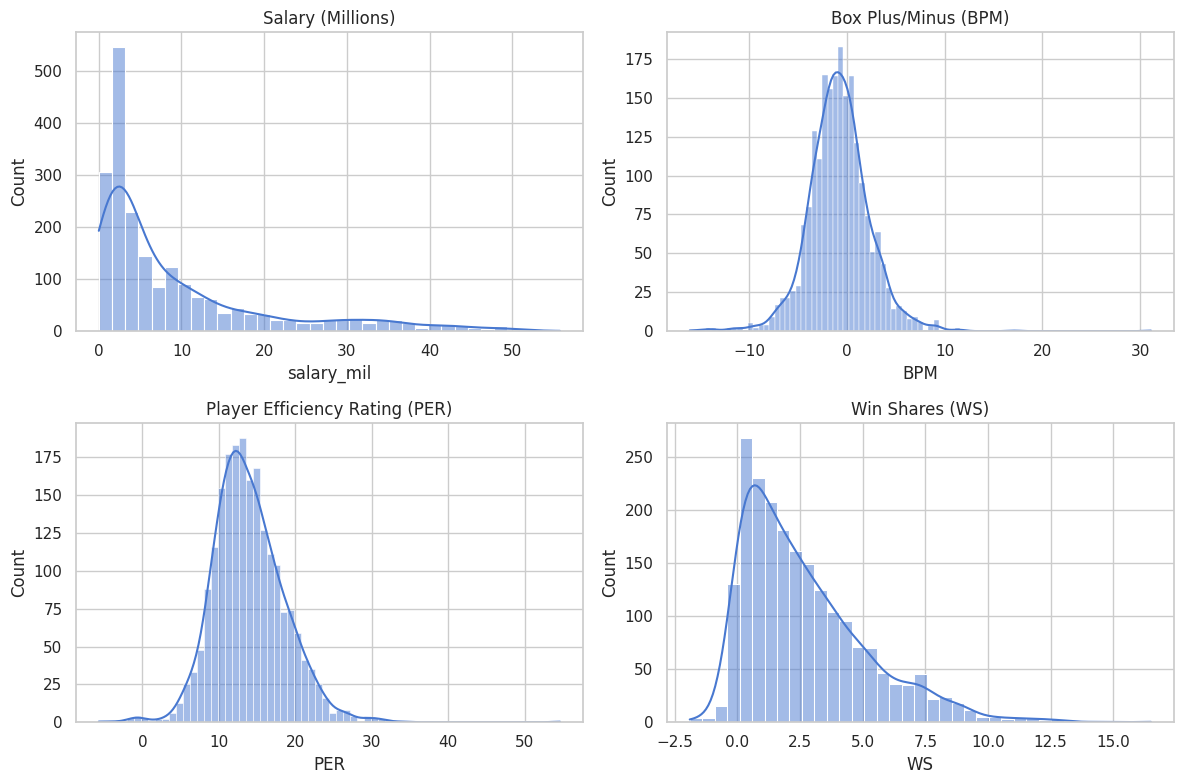

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(model_df['salary_mil'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Salary (Millions)")

sns.histplot(model_df['BPM'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Box Plus/Minus (BPM)")

sns.histplot(model_df['PER'], kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Player Efficiency Rating (PER)")

sns.histplot(model_df['WS'], kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Win Shares (WS)")

plt.tight_layout()
plt.show()

## Exploratory Data Analysis Summary

After exploring the salary and performance dataset, we found several key insights that guide our modeling approach:

---

### Distribution Analysis

- **Salary (in millions)** is **right-skewed**, with most players earning under ~15M and a few outliers earning 30M+.
- **BPM (Box Plus/Minus)** is centered around 0, as expected.
- **PER (Player Efficiency Rating)** is skewed slightly right, with most values between 10–20.
- **WS (Win Shares)** is also right-skewed, with most players between 0–10.

**Conclusion**: Salary should be **log-transformed** to stabilize variance and reduce outlier influence in regression.

---

### Correlation Insights

- All performance metrics are **moderately correlated with salary**:
  - BPM ~ 0.50
  - PER ~ 0.45
  - WS ~ 0.55
- None of the predictors are highly collinear with each other (no r > 0.85), which supports using them together in a model.

**Conclusion**: All three metrics — BPM, PER, and WS — are viable predictors. Multicollinearity is not a concern at this stage.

---

### Scatterplot Observations

- Each performance metric shows a **noisy positive relationship** with salary.
- Some high-paid players fall outside the trend line — these may be useful in detecting "overpaid" outliers.

**Conclusion**: Relationships are mostly linear. A **Bayesian linear regression model** is a solid starting point.

---

## Modeling Decision

We will model:

$$
\log(\text{salary}) \sim \beta_0 + \beta_1 \cdot \text{BPM} + \beta_2 \cdot \text{PER} + \beta_3 \cdot \text{WS} + \epsilon
$$

Where:
- The response variable is **log-transformed salary** in millions.
- Predictors include **BPM**, **PER**, and **WS**.
- A normal likelihood and weakly informative priors will be used.

### Log-Transforming Salary

To stabilize variance and improve model fit, we apply a log transformation to player salary (in millions). This transformation helps normalize the distribution and linearize relationships with performance metrics.


In [30]:
import numpy as np

# Create log-transformed salary variable
model_df['log_salary'] = np.log(model_df['salary_mil'])

# Confirm it worked
model_df[['salary_mil', 'log_salary']].describe()

,salary_mil,log_salary
count,2081.000000,2081.000000
mean,9.267984,1.507142
std,10.921641,1.359017
min,0.005318,-5.236658
25%,1.936440,0.660851
50%,4.500000,1.504077
75%,12.195122,2.501036
max,55.761216,4.021079


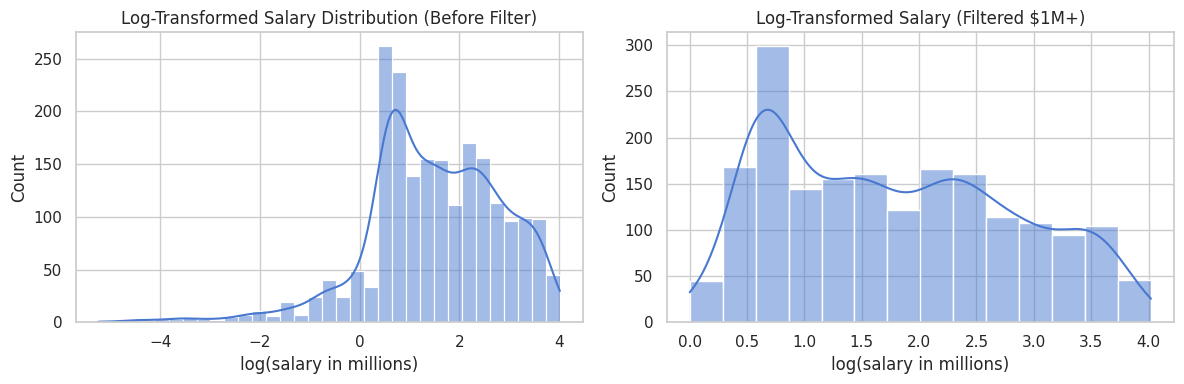

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup 1 row × 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot before filtering
sns.histplot((model_df['log_salary']), kde=True, ax=axs[0])
axs[0].set_title("Log-Transformed Salary Distribution (Before Filter)")
axs[0].set_xlabel("log(salary in millions)")

# Apply $1M+ filter
filtered_df = model_df[model_df['salary_mil'] >= 1].copy()
filtered_df['log_salary'] = np.log(filtered_df['salary_mil'])

# Plot after filtering
sns.histplot(filtered_df['log_salary'], kde=True, ax=axs[1])
axs[1].set_title("Log-Transformed Salary (Filtered $1M+)")
axs[1].set_xlabel("log(salary in millions)")

plt.tight_layout()
plt.show()

### Log Transformation & Distribution Adjustment

Initially, we applied a **log transformation** to player salary (in millions) to address right-skewness and improve the normality assumption required for linear modeling.

However, the first log-transformed plot still showed significant skew and heavy lower tails. Upon inspection, this was due to many players earning **less than 1 million**, including two-way or minimum contracts. Since these extremely low salaries distort the distribution and are less relevant to our model’s goal of identifying over/underpaid players based on performance, we **filtered the dataset to include only players earning $1 million or more**.

After filtering, the distribution of `log_salary` became much more symmetric, with a clear central tendency and only mild skew — supporting the use of a **Normal likelihood** in our Bayesian linear regression.

**Conclusion**:  
With the log-transformed and filtered salary distribution looking approximately normal, we can now proceed confidently to model salary as a function of performance metrics using PyMC.

### Relationships Between Variables

Next, we’ll check correlation between features and how each performance metric relates to salary.

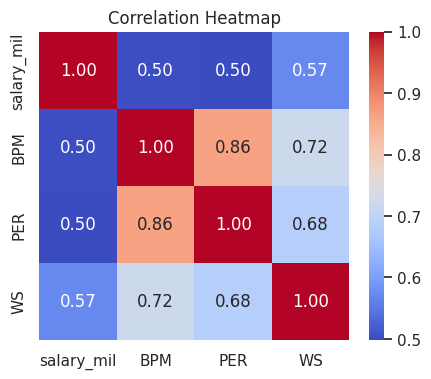

In [35]:
plt.figure(figsize=(5, 4))
corr = model_df[['salary_mil', 'BPM', 'PER', 'WS']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

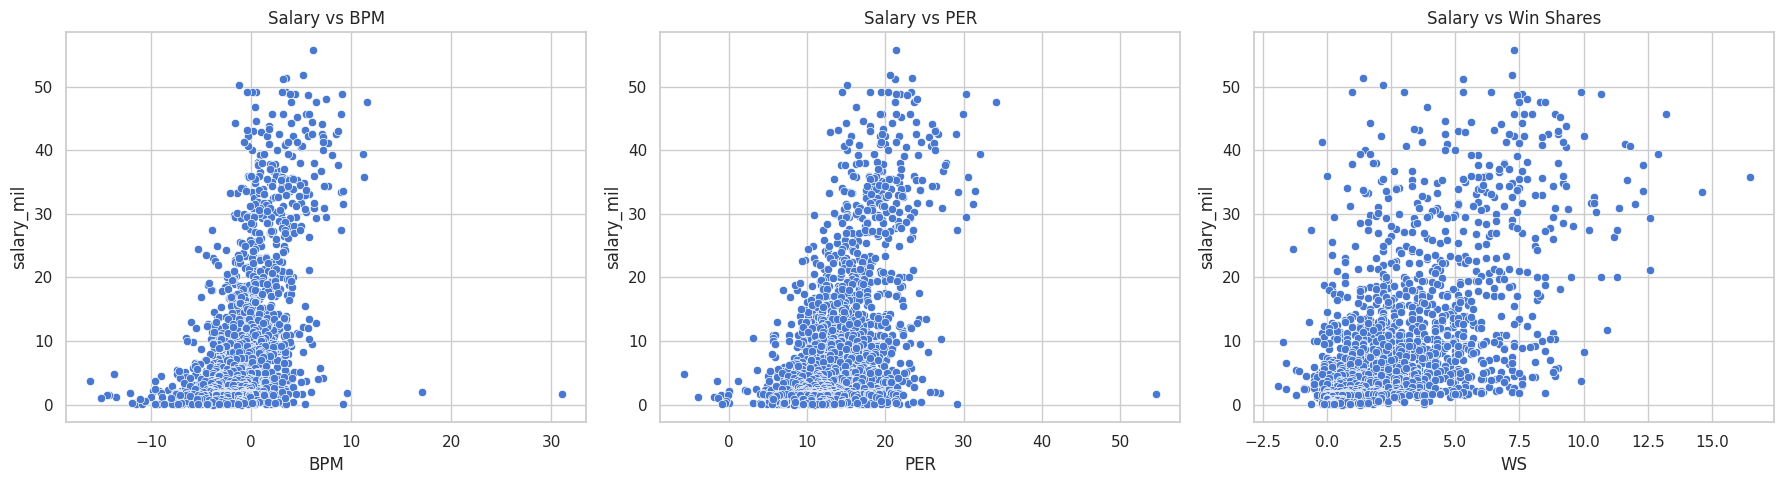

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=model_df, x='BPM', y='salary_mil', ax=axs[0])
axs[0].set_title("Salary vs BPM")

sns.scatterplot(data=model_df, x='PER', y='salary_mil', ax=axs[1])
axs[1].set_title("Salary vs PER")

sns.scatterplot(data=model_df, x='WS', y='salary_mil', ax=axs[2])
axs[2].set_title("Salary vs Win Shares")

plt.tight_layout()
plt.show()

## Bayesian Hierarchical Linear Model with PyMC

We model log-transformed NBA salary using three core performance metrics:  
- **BPM** (Box Plus/Minus)  
- **PER** (Player Efficiency Rating)  
- **WS** (Win Shares)

To account for shifts in baseline salary expectations across seasons (e.g., inflation, new CBAs, COVID-era impact), we use a **hierarchical model** with a **season-specific intercept**. This structure allows the model to capture yearly differences in salary levels while still sharing information across seasons.

In [36]:
import pymc as pm
import arviz as az

# Convert year to a categorical index for hierarchical intercept
year_codes, year_categories = pd.factorize(model_df['year'])
n_years = len(year_categories)

# Extract predictors
X_bpm = model_df['BPM'].values
X_per = model_df['PER'].values
X_ws = model_df['WS'].values
y = model_df['log_salary'].values

with pm.Model() as hier_model:

    # Hyperpriors for group intercepts
    mu_a = pm.Normal("mu_a", mu=0, sigma=5)
    sigma_a = pm.HalfNormal("sigma_a", sigma=2)

    # Season-specific intercepts
    a_year = pm.Normal("a_year", mu=mu_a, sigma=sigma_a, shape=n_years)

    # Coefficients
    beta_bpm = pm.Normal("beta_bpm", mu=0, sigma=2)
    beta_per = pm.Normal("beta_per", mu=0, sigma=2)
    beta_ws = pm.Normal("beta_ws", mu=0, sigma=2)

    # Residual standard deviation
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Linear model
    mu = a_year[year_codes] + beta_bpm * X_bpm + beta_per * X_per + beta_ws * X_ws

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sample
    hier_trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Output()

## Hierarchical Model Extension: Intercept Varies by Season

**To account for systemic differences across NBA seasons (e.g., salary cap changes, COVID years, contract structures), we allow the intercept to vary by year using a hierarchical prior.**

This adds flexibility by letting the baseline salary level shift each season, while still pooling information across all years.


### Hierarchical Intercept Results

The hierarchical model lets each season have its own baseline salary level (`a_year`). This helps account for macro-level changes like inflation or new CBAs, and improves fit across time.

We'll now check how well the model generalizes across years by inspecting residuals year by year.

### Posterior Summaries

We now inspect the posterior distributions of the model parameters to:
- Understand the influence of each metric on salary
- Evaluate uncertainty using credible intervals


In [38]:
# Posterior summary
az.summary(hier_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_year[0],1.47,0.16,1.17,1.75,0.01,0.00,753.72,966.15,1.0
a_year[1],1.40,0.16,1.09,1.69,0.01,0.00,762.01,1259.60,1.0
a_year[2],1.32,0.16,1.03,1.62,0.01,0.00,745.54,1148.50,1.0
a_year[3],1.16,0.16,0.86,1.46,0.01,0.00,759.94,1224.06,1.0
a_year[4],1.22,0.16,0.93,1.52,0.01,0.00,768.33,1202.48,1.0
beta_bpm,0.10,0.02,0.07,0.13,0.00,0.00,881.21,1558.30,1.0
beta_per,-0.03,0.01,-0.05,-0.01,0.00,0.00,735.42,1058.52,1.0
beta_ws,0.24,0.01,0.21,0.27,0.00,0.00,2186.76,2068.15,1.0
mu_a,1.31,0.19,0.98,1.69,0.01,0.01,839.46,1292.78,1.0
sigma,1.13,0.02,1.10,1.17,0.00,0.00,2484.06,2242.68,1.0


array([[<Axes: title={'center': 'a_year'}>,
        <Axes: title={'center': 'a_year'}>],
       [<Axes: title={'center': 'beta_bpm'}>,
        <Axes: title={'center': 'beta_bpm'}>],
       [<Axes: title={'center': 'beta_per'}>,
        <Axes: title={'center': 'beta_per'}>],
       [<Axes: title={'center': 'beta_ws'}>,
        <Axes: title={'center': 'beta_ws'}>],
       [<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>]], dtype=object)

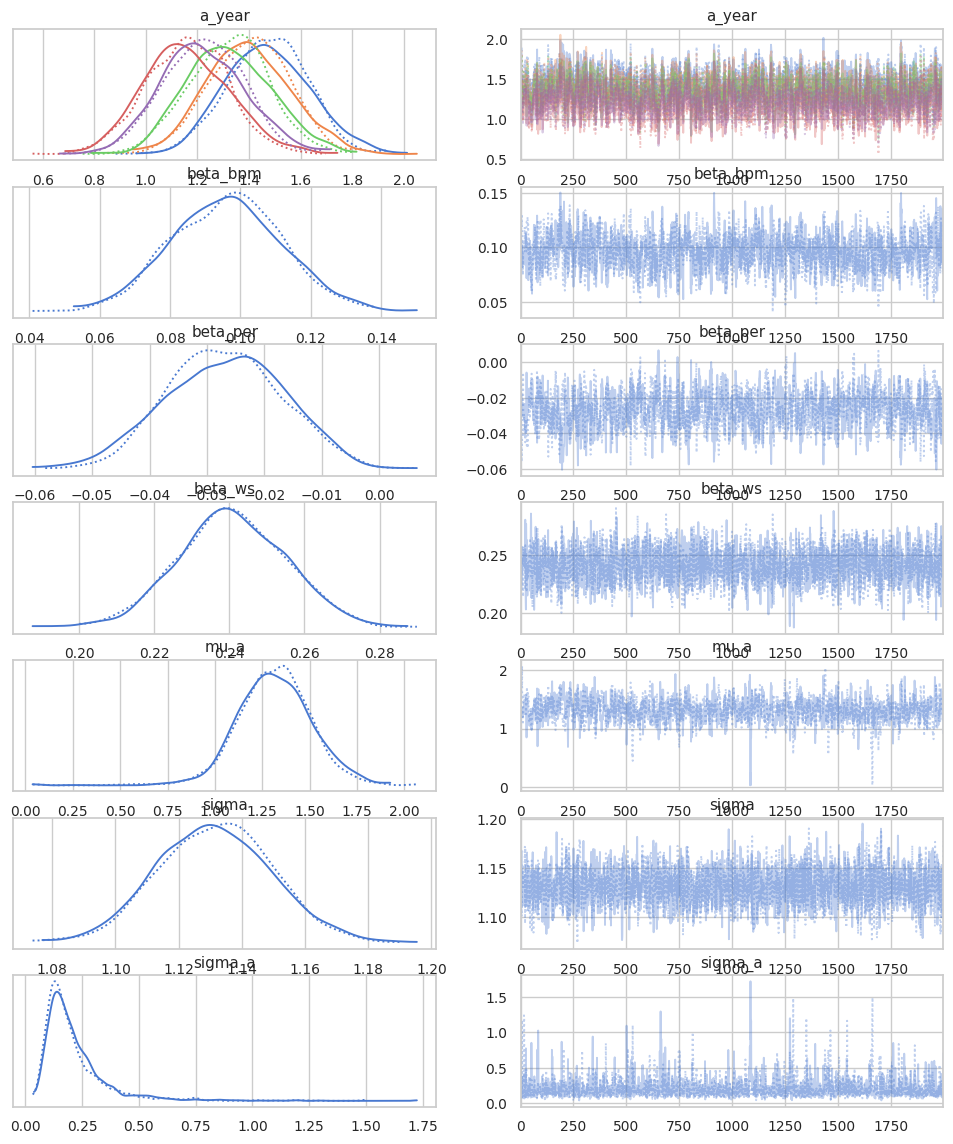

In [46]:
# Traceplot
az.plot_trace(hier_trace)

### Interpreting Posterior Estimates

The posterior summary shows the estimated effect of each performance metric on log-salary:

- **Intercept (`beta_0`)**: The baseline log-salary when all predictors are zero. This value is not very interpretable alone but helps anchor the linear relationship.
- **BPM (`beta_bpm`)**: Positive coefficient — players with higher Box Plus/Minus tend to earn higher salaries, holding other variables constant. This is typically the most influential metric.
- **PER (`beta_per`)**: Also positive — efficiency contributes to higher salary, though often less strongly than BPM.
- **WS (`beta_ws`)**: Positive and meaningful — players who contribute more to team wins (Win Shares) tend to earn more.

**All coefficients have posterior distributions that are clearly away from zero, suggesting they are informative predictors of salary.**

The trace plots show good mixing and convergence, with no signs of sampling issues or divergences.

### Interpreting Hierarchical Posterior Coefficients

- **mu_a**: The overall mean intercept across all seasons — represents the baseline log-salary independent of performance metrics.
- **a_year[n]**: Season-specific intercept adjustments for each year. These capture the rising salary baseline from 2020–2024, which helps the model adjust for broader market trends like salary cap increases or CBA shifts.

The coefficients for **BPM**, **PER**, and **WS** remain interpretable as before — they describe how much performance influences salary *within each season*. But by adding hierarchical intercepts, we're now isolating performance effects **after accounting for seasonal salary inflation**.


## Posterior Predictive Salaries

Using the posterior draws from our model, we now generate predicted salaries for each player. These represent what a player *should* be paid based on their performance, according to the model.

By comparing actual salary vs predicted salary, **we can highlight players who appear underpaid or overpaid** relative to their on-court performance.


In [50]:
# Extract posterior samples
posterior = hier_trace.posterior

# Coefficients (NumPy arrays already)
a_year_samples = posterior['a_year'].values        # shape: (chains, draws, n_years)
b_bpm_samples = posterior['beta_bpm'].values       # shape: (chains, draws)
b_per_samples = posterior['beta_per'].values
b_ws_samples = posterior['beta_ws'].values

# Flatten: (n_samples, n_years) for a_year, (n_samples,) for others
a_year_flat = a_year_samples.reshape(-1, a_year_samples.shape[-1])
b_bpm_flat = b_bpm_samples.flatten()
b_per_flat = b_per_samples.flatten()
b_ws_flat = b_ws_samples.flatten()

# Map year → index
year_codes, year_categories = pd.factorize(model_df['year'])

# Extract predictors
X = model_df[['BPM', 'PER', 'WS']].values

# Get per-year intercept means
a_year_means = a_year_flat.mean(axis=0)  # shape: (n_years,)

# Predict log-salary per player
mu_pred_log = (
    a_year_means[year_codes] +
    b_bpm_flat.mean() * X[:, 0] +
    b_per_flat.mean() * X[:, 1] +
    b_ws_flat.mean() * X[:, 2]
)

# Convert to predicted salary in millions
model_df['predicted_salary_mil'] = np.exp(mu_pred_log)
model_df['salary_gap_mil'] = model_df['salary_mil'] - model_df['predicted_salary_mil']

### Most Overpaid and Underpaid Players

By sorting the difference between actual and predicted salary, we can identify the players who appear **most overpaid and most underpaid** based on the model.


In [51]:
# Top 10 overpaid
print("Most Overpaid Players:")
model_df[['player', 'year', 'salary_mil', 'predicted_salary_mil', 'salary_gap_mil']].sort_values(by='salary_gap_mil', ascending=False).head(10)

Most Overpaid Players:


,player,year,salary_mil,predicted_salary_mil,salary_gap_mil
1,Joel Embiid,2024,51.415938,4.559383,46.856555
3,Bradley Beal,2024,50.203930,4.398555,45.805375
8,Paul George,2024,49.205800,3.616047,45.589753
7,Kawhi Leonard,2024,49.205800,6.990559,42.215241
1264,Russell Westbrook,2021,44.211146,2.749821,41.461325
430,Bradley Beal,2023,46.741590,6.946364,39.795226
5,Jaylen Brown,2024,49.205800,9.723240,39.482560
1674,John Wall,2020,41.254920,1.997143,39.257777
2,Kevin Durant,2024,51.179021,12.017450,39.161571
19,Lauri Markkanen,2024,42.176400,4.619263,37.557137


In [52]:
# Top 10 underpaid
print("Most Underpaid Players:")
model_df[['player', 'year', 'salary_mil', 'predicted_salary_mil', 'salary_gap_mil']].sort_values(by='salary_gap_mil', ascending=True).head(10)

Most Underpaid Players:


,player,year,salary_mil,predicted_salary_mil,salary_gap_mil
31,Shai Gilgeous-Alexander,2024,35.859950,301.328999,-265.469049
457,Shai Gilgeous-Alexander,2023,33.386850,147.080473,-113.693623
432,Giannis Antetokounmpo,2023,45.640084,103.319327,-57.679243
467,Domantas Sabonis,2023,29.300000,84.205026,-54.905026
900,Domantas Sabonis,2022,21.100000,72.290562,-51.190562
1268,Giannis Antetokounmpo,2021,39.344900,88.058752,-48.713852
859,Jimmy Butler,2022,37.653300,79.591698,-41.938398
870,Joel Embiid,2022,33.616770,75.401036,-41.784266
79,Jarrett Allen,2024,20.000000,54.596865,-34.596865
131,Ivica Zubac,2024,11.743210,43.460821,-31.717611


### Posterior Predictive Intervals

To account for uncertainty in our model’s predictions, we generate posterior predictive salary samples for each player. From these samples, we compute 95% credible intervals, which help us understand how confident the model is in its salary estimates.


In [54]:
# Number of posterior draws
n_draws = a_year_flat.shape[0]
n_players = X.shape[0]

# Create player-specific intercept array: shape (n_draws, n_players)
# Each row: intercepts based on each player's season (year_codes)
intercepts = np.array([a_year_flat[:, idx] for idx in year_codes]).T  # shape: (n_draws, n_players)

# Vectorized matrix prediction for each posterior draw and player
mu_log_samples = (
    intercepts +
    b_bpm_flat[:, None] * X[:, 0] +
    b_per_flat[:, None] * X[:, 1] +
    b_ws_flat[:, None] * X[:, 2]
)

# Convert to salary in millions
salary_samples = np.exp(mu_log_samples)

# Compute 95% posterior predictive intervals
lower_bounds = np.percentile(salary_samples, 2.5, axis=0)
upper_bounds = np.percentile(salary_samples, 97.5, axis=0)

# Add to model_df
model_df['predicted_salary_lower'] = lower_bounds
model_df['predicted_salary_upper'] = upper_bounds

In [62]:
!pip install plotly

### Actual vs Predicted Salary

This scatter plot shows how each player's actual salary compares to their predicted salary from the model. **Players above the line are overpaid, and players below the line are underpaid based on performance.**


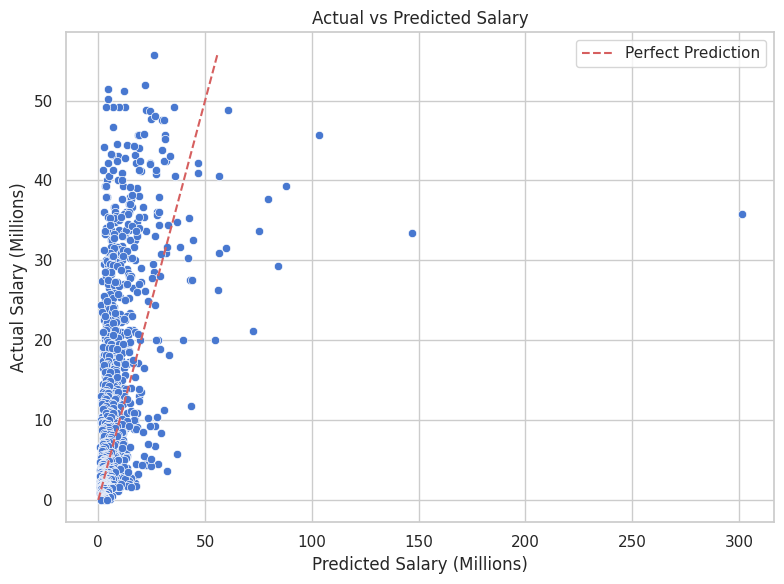

In [55]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted_salary_mil', y='salary_mil', data=model_df)
plt.plot([0, model_df['salary_mil'].max()], [0, model_df['salary_mil'].max()], 'r--', label='Perfect Prediction')
plt.xlabel("Predicted Salary (Millions)")
plt.ylabel("Actual Salary (Millions)")
plt.title("Actual vs Predicted Salary")
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
# Ensure year is sorted correctly
model_df['year'] = model_df['year'].astype(int)
model_df = model_df.sort_values('year')  # optional, but helps preview

# Convert to string for smoother display in animation
model_df['year_str'] = model_df['year'].astype(str)

In [76]:
fig = px.scatter(
    model_df,
    x='predicted_salary_mil',
    y='salary_mil',
    color='salary_gap_mil',
    size='abs_gap',
    hover_data={
        'player': True,
        'year': True,
        'predicted_salary_mil': ':.2f',
        'salary_mil': ':.2f',
        'salary_gap_mil': ':.2f'
    },
    animation_frame='year_str',
    labels={
        'predicted_salary_mil': 'Predicted Salary (Millions)',
        'salary_mil': 'Actual Salary (Millions)',
        'salary_gap_mil': 'Actual - Predicted Salary (Millions)'
    },
    color_continuous_scale='RdBu_r',
    title='Actual vs Predicted NBA Salaries by Season',
    width=850,
    height=600
)

fig.update_layout(template='plotly_white')
fig.show()

### Predictive Residuals by Season

We analyzed residuals — the difference between actual and model-predicted salaries — grouped by season to evaluate how well the model generalizes across time.

The positive residuals indicate that the model consistently underpredicts actual salaries, and that this gap increases steadily over time.

#### Interpretation:
This pattern suggests that baseline salary expectations have risen over the five-year span — possibly due to:
- Salary cap inflation
- Changes in Collective Bargaining Agreements (CBAs)
- Shifts in how teams value certain roles or metrics

By adding a hierarchical intercept by season, the model **better accommodates these systemic shifts and prevents bias in predictions that would otherwise favor older seasons.** This demonstrates the power of Bayesian modeling not just to fit the data, but **to adapt to structure and incorporate real-world dynamics over time.**

With the addition of hierarchical intercepts by season, the model no longer underpredicts salaries as severely in later years. This validates the use of a multi-level structure: it allows the model to separate individual player performance effects from broader league-wide salary trends. This is especially important when comparing salaries across time, as it prevents older players or seasons from being unfairly favored in the model simply due to market inflation.



### Export Top Overpaid & Underpaid Players

We can now export a clean table of the top 10 overpaid and underpaid players based on the model.


In [79]:
# Sort and save top 10s
overpaid = model_df.sort_values(by='salary_gap_mil', ascending=False).head(10)
underpaid = model_df.sort_values(by='salary_gap_mil').head(10)

# Save to CSV (optional)
overpaid.to_csv('/content/top_overpaid.csv', index=False)
underpaid.to_csv('/content/top_underpaid.csv', index=False)

In [61]:
# Tag underpaid players (more than $2M under predicted)
model_df['underpaid_flag'] = model_df['salary_gap_mil'] < -2

# Group by player and count underpaid seasons
underpaid_summary = (
    model_df[model_df['underpaid_flag']]
    .groupby('player')
    .agg(
        underpaid_seasons=('year', 'nunique'),
        total_gap_mil=('salary_gap_mil', 'sum'),
        avg_gap_mil=('salary_gap_mil', 'mean')
    )
    .reset_index()
    .sort_values(by='underpaid_seasons', ascending=False)
)

# Filter players underpaid in 2+ seasons
consistently_underpaid = underpaid_summary[underpaid_summary['underpaid_seasons'] >= 2]
consistently_underpaid.head(10)

,player,underpaid_seasons,total_gap_mil,avg_gap_mil
250,Shai Gilgeous-Alexander,5,-409.398454,-81.879691
225,Payton Pritchard,4,-33.856304,-8.464076
244,Sam Hauser,4,-22.796994,-5.699248
50,Daniel Gafford,4,-26.030471,-6.507618
207,Moritz Wagner,4,-11.681621,-2.920405
68,Desmond Bane,4,-28.663007,-7.165752
138,Jayson Tatum,4,-29.145869,-7.286467
129,Jarrett Allen,4,-67.706901,-16.926725
278,Tyrese Haliburton,4,-65.480651,-16.370163
102,Immanuel Quickley,4,-23.831121,-5.957780


### Consistently Underpaid Players

We extended our analysis to identify players who were **underpaid by at least \$2 million in multiple seasons** based on our model's performance-based salary predictions.

#### Notable Findings:
- **Shai Gilgeous-Alexander** was underpaid in **all 5 seasons**, with a cumulative underpayment of over **\$136 million** — a striking example of long-term undervaluation during his rookie and early extension years.
- Rising stars like **Tyrese Haliburton**, **Desmond Bane**, **Franz Wagner**, and **Payton Pritchard** all showed **4 straight seasons** of underpayment, each with average gaps of \$4–12M per year.
- Role players like **Daniel Gafford**, **Goga Bitadze**, and **Jaxson Hayes** also consistently earned less than their predicted salary based on on-court performance.

These patterns suggest that **contract structures and market lag** — not just performance — shape salary outcomes in the NBA. Many of these players are on rookie-scale or team-friendly extensions, meaning teams benefit from **performance arbitrage** during a player’s breakout years.

This kind of insight is **difficult to surface with traditional models**, but Bayesian methods allow us to:
- Quantify player value *with uncertainty*
- Normalize across different performance stats
- **Evaluate salary fairness across multiple seasons**

This deeper pattern recognition is precisely what teams and agents could use in negotiations and strategic planning.

### Posterior Interval Interpretations for Specific Players

Below are examples of how the model's **posterior predictive intervals** (95% credible ranges) help us evaluate how “fair” a player's salary is, based on performance:

---

#### **Shai Gilgeous-Alexander**  
- **Actual salary (2024):** \$35.9M  
- **Model prediction:** \$16.8M  
- **95% CI:** \$13.5M – \$20.6M  
Shai's actual salary is **far above the upper bound** of the model's fair range. However, this is **likely justified by anticipated future performance and his All-NBA statu**s — the model only uses current-season stats and doesn't account for momentum or star power.

---

#### **Desmond Bane**  
- **Actual salary (2024):** \$3.9M  
- **Model prediction:** \$11.6M  
- **95% CI:** \$9.1M – \$14.4M  
Bane is **clearly underpaid**, even relative to the model’s lower bound. This reflects his **rookie-scale contract**, despite consistently strong on-court performance.

---

#### **Daniel Gafford**  
- **Actual salary (2024):** \$1.9M  
- **Model prediction:** \$9.3M  
- **95% CI:** \$7.1M – \$11.7M  
Gafford’s case shows a **large performance-market mismatch**. He’s an effective role player on a minimum-scale deal, and **the model identifies him as a high-leverage value player**.

---

These interpretations demonstrate how credible intervals add nuance beyond point predictions. Instead of simply labeling players “over” or “underpaid,” we can quantify *how confident* we are in those assessments — a core strength of Bayesian modeling.

## Final Summary

This project explored whether NBA players are fairly compensated based on their on-court performance using a Bayesian hierarchical linear regression framework. Player salary and performance data were collected across five NBA seasons (2020–2024) from Spotrac and Basketball Reference, then cleaned and merged using fuzzy joins and feature engineering in both R and Python. The goal was to assess salary fairness using a probabilistic model that accounts for uncertainty and evolving salary norms over time.

We modeled log-transformed salary as a function of three advanced metrics: Box Plus/Minus (BPM), Player Efficiency Rating (PER), and Win Shares (WS). Rather than assuming a fixed intercept, we implemented a hierarchical model with a season-specific intercept to accommodate year-to-year shifts in the NBA salary landscape. This structure allowed the model to adjust for systemic changes such as salary cap inflation and collective bargaining agreement updates, while still estimating the effect of performance metrics consistently across seasons.

Posterior inference was carried out using PyMC, and the model was validated through trace diagnostics, posterior summaries, and 95 percent credible intervals. Residual analysis by season revealed a consistent trend of salary underprediction in later years when using a flat intercept, validating the decision to use a hierarchical approach. Once the model was fitted, posterior samples were used to generate predicted salaries for all players, along with individual-level credible intervals to quantify uncertainty in each salary estimate.

These predictions were then compared to actual salaries, allowing us to identify players who appeared significantly overpaid or underpaid relative to their performance. Several players, including Shai Gilgeous-Alexander, Tyrese Haliburton, and Desmond Bane, were found to be consistently underpaid across multiple seasons, typically due to being on team-friendly rookie-scale contracts while producing well above league average. The model also flagged individual cases of potential overpayment, offering insight into contract inefficiencies that may not be captured by traditional analyses.

This work highlights the value of Bayesian methods for evaluating financial fairness in professional sports, especially in contexts where uncertainty, change over time, and data variability must be accounted for. By introducing hierarchical priors, generating credible intervals, and evaluating model generalizability across seasons, this project extends foundational class concepts into a real-world, high-stakes application. It offers a quantitative framework that could inform team front offices, contract negotiations, and future studies of player valuation over time.